<a href="https://colab.research.google.com/github/Sim98B/ShroomVision/blob/main/SV4/ShroomVision4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
try:
  import torch
  print(f"torch: {torch.__version__}")
  import torchvision
  print(f"torchvision: {torchvision.__version__}")
except:
  print("[INFO] Torch and Torchvision not installed, downloading")
  !pip install torch torchvision
  import torch
  import torchvision

import os
import zipfile
from pathlib import Path
import requests
import shutil
from timeit import default_timer as timer
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from torch import nn
from torchvision import transforms

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

!git clone https://github.com/Sim98B/ShroomVision
!mv ShroomVision/Modules/Libraries .

from Libraries import data, utils, model_ops

shutil.rmtree("ShroomVision")

torch: 2.1.0+cu118
torchvision: 0.16.0+cu118
Cloning into 'ShroomVision'...
remote: Enumerating objects: 2584, done.
remote: Counting objects: 100% (1037/1037), done.
remote: Compressing objects: 100% (717/717), done.
remote: Total 2584 (delta 327), reused 949 (delta 288), pack-reused 1547
Receiving objects: 100% (2584/2584), 255.89 MiB | 14.66 MiB/s, done.
Resolving deltas: 100% (463/463), done.


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [3]:
data_path = data.download_data(source = "https://github.com/Sim98B/ShroomVision/raw/main/Data/SV4_data.zip",
                               remove_source = True)

train_dir = data_path.joinpath("train_data")
val_dir = data_path.joinpath("val_data")
test_dir = data_path.joinpath("test_data")
data_path

[INFO] Did not find data directory, creating one...
[INFO] Downloading SV4_data.zip from https://github.com/Sim98B/ShroomVision/raw/main/Data/SV4_data.zip...
[INFO] Unzipping SV4_data.zip data...


PosixPath('data/SV4_data')

In [4]:
data.inspect_dir(data_path)

There are 3 directory/ies and 0 file/s in data/SV4_data
There are 4 directory/ies and 0 file/s in data/SV4_data/test_data
There are 0 directory/ies and 51 file/s in data/SV4_data/test_data/amanita_vaginata
There are 0 directory/ies and 111 file/s in data/SV4_data/test_data/boletus_edulis
There are 0 directory/ies and 171 file/s in data/SV4_data/test_data/amanita_muscaria
There are 0 directory/ies and 39 file/s in data/SV4_data/test_data/boletus_erythropus
There are 4 directory/ies and 0 file/s in data/SV4_data/val_data
There are 0 directory/ies and 64 file/s in data/SV4_data/val_data/amanita_vaginata
There are 0 directory/ies and 64 file/s in data/SV4_data/val_data/boletus_edulis
There are 0 directory/ies and 64 file/s in data/SV4_data/val_data/amanita_muscaria
There are 0 directory/ies and 64 file/s in data/SV4_data/val_data/boletus_erythropus
There are 4 directory/ies and 0 file/s in data/SV4_data/train_data
There are 0 directory/ies and 200 file/s in data/SV4_data/train_data/amanita

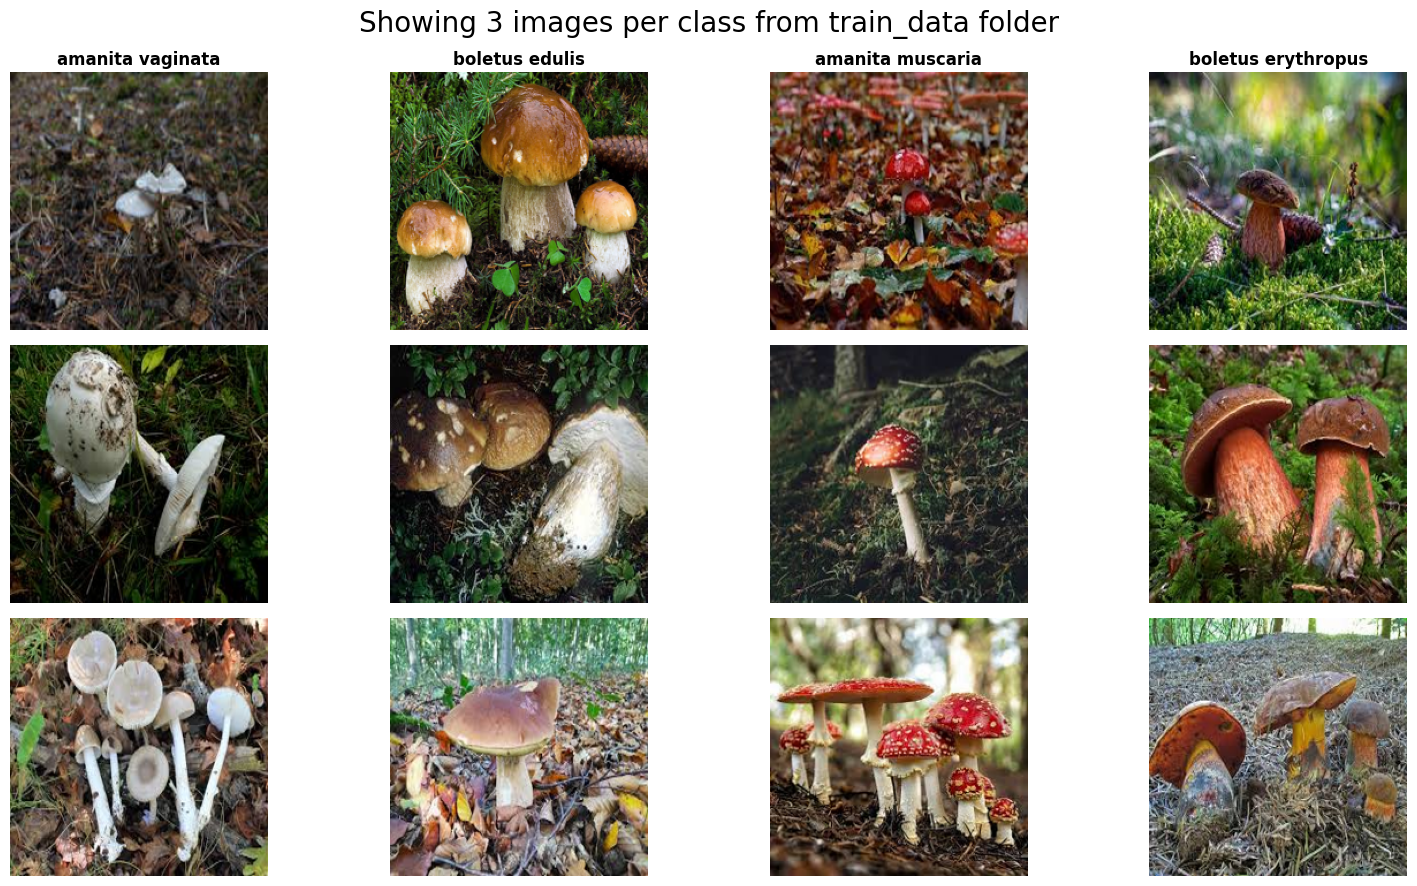

In [5]:
data.plot_random_images(data_path = data_path,
                        target_folder = "train_data")

In [44]:
sv4_transformer = transforms.Compose([transforms.Resize(size=(128, 128)),
                                 transforms.ToTensor()])

train_loader, class_names  = data.dataloader(train_dir, transformer = sv4_transformer, bs = 32, shuffle = True)
val_loader, _  = data.dataloader(val_dir, transformer = sv4_transformer, bs = 32, shuffle = False)
test_loader, _  = data.dataloader(test_dir, transformer = sv4_transformer, bs = 32, shuffle = False)

train_loader, val_loader, test_loader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7a8b778575e0>,
 ['amanita_muscaria',
  'amanita_vaginata',
  'boletus_edulis',
  'boletus_erythropus'])

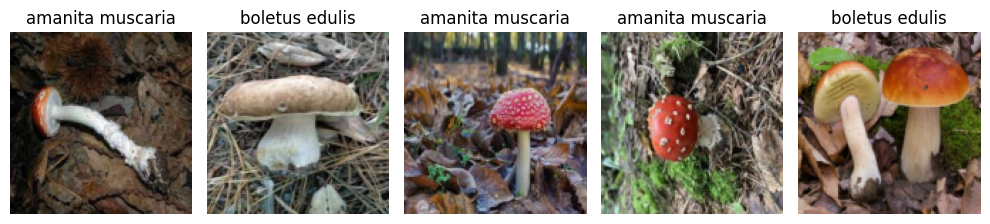

In [45]:
data.plot_dataloader_img(dataloader = train_loader,
                         n_images = 5,
                         classes = class_names)

In [46]:
utils.set_seed()
baseline = utils.linear_baseline(input_height = 128,
                                 input_width = 128,
                                 color_channels = 3,
                                 output_shape = 4,
                                 num_layers = 3,
                                 num_neurons = 10).to(device)
baseline

Baseline(
  (model): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=49152, out_features=10, bias=True)
    (2): ReLU()
    (3): Linear(in_features=10, out_features=10, bias=True)
    (4): ReLU()
    (5): Linear(in_features=10, out_features=10, bias=True)
    (6): ReLU()
    (7): Linear(in_features=10, out_features=4, bias=True)
  )
)

In [47]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(baseline.parameters(),
                             lr=0.001)

In [49]:
start = timer()

baseline_results = model_ops.train(model = baseline,
                                   train_dataloader = train_loader,
                                   test_dataloader = val_loader,
                                   loss_function = loss_fn,
                                   optimizer = optimizer,
                                   metric = "accuracy",
                                   epochs = 20,
                                   device = "cpu",
                                   verbose = 2)
end = timer()

utils.delta_time(start, end)

Training:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 01: Train Loss: 1.333 | Train Accuracy: 31.13% | Test Loss: 1.311 | Test Accuracy: 33.20%
Epoch 02: Train Loss: 1.273 | Train Accuracy: 41.38% | Test Loss: 1.307 | Test Accuracy: 35.55%
Epoch 03: Train Loss: 1.271 | Train Accuracy: 41.12% | Test Loss: 1.245 | Test Accuracy: 42.97%
Epoch 04: Train Loss: 1.199 | Train Accuracy: 43.38% | Test Loss: 1.219 | Test Accuracy: 41.41%
Epoch 05: Train Loss: 1.158 | Train Accuracy: 44.75% | Test Loss: 1.191 | Test Accuracy: 41.41%
Epoch 06: Train Loss: 1.104 | Train Accuracy: 47.88% | Test Loss: 1.164 | Test Accuracy: 45.31%
Epoch 07: Train Loss: 1.054 | Train Accuracy: 51.00% | Test Loss: 1.130 | Test Accuracy: 46.48%
Epoch 08: Train Loss: 1.017 | Train Accuracy: 53.62% | Test Loss: 1.115 | Test Accuracy: 48.05%
Epoch 09: Train Loss: 0.986 | Train Accuracy: 56.00% | Test Loss: 1.104 | Test Accuracy: 48.05%
Epoch 10: Train Loss: 0.932 | Train Accuracy: 56.75% | Test Loss: 1.115 | Test Accuracy: 49.22%
Epoch 11: Train Loss: 0.860 | Train Accu

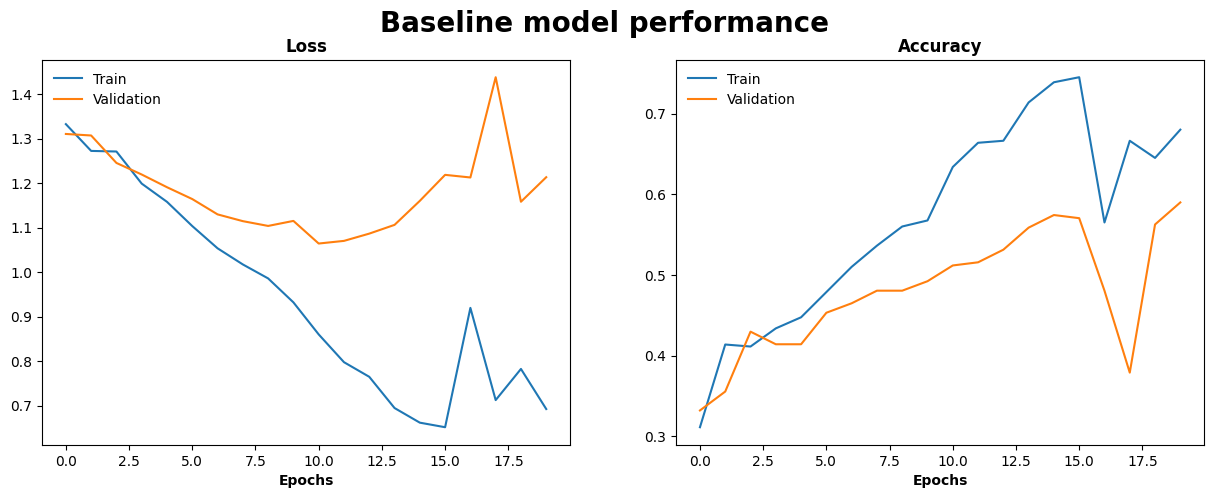

In [50]:
utils.plot_model_performance(results_dict = baseline_results,
                             fig_size = (15, 5),
                             metric_name = "Accuracy",
                             title = "Baseline model performance")

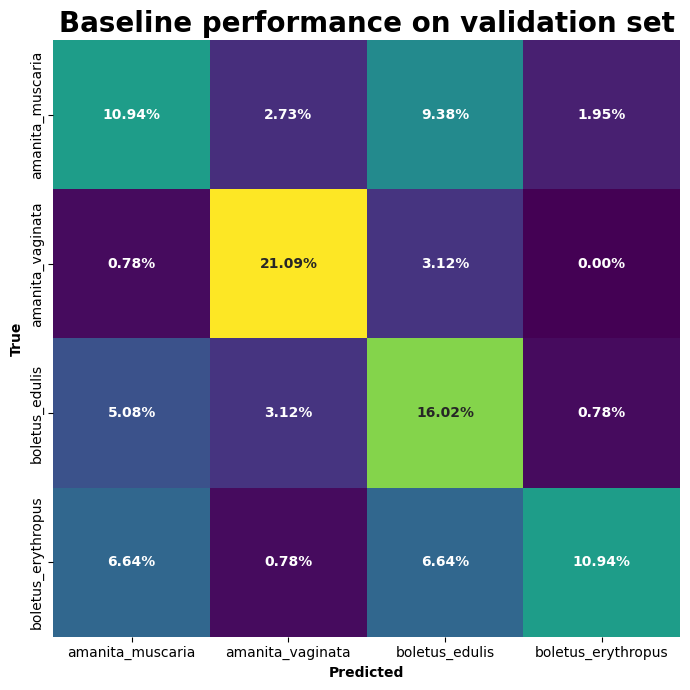

In [51]:
val_pred, val_true = model_ops.make_predictions(model = baseline,
                                                test_dataloader = val_loader)

utils.plot_confusion_matrix(y_true = val_true,
                            y_pred = val_pred,
                            class_names = class_names,
                            norm = "all",
                            title = "Baseline performance on validation set")

In [52]:
sv4_transformer_augmentation = transforms.Compose([transforms.Resize(size=(128, 128)),
                                                   transforms.TrivialAugmentWide(num_magnitude_bins = 31),
                                                   transforms.ToTensor()])

train_loader_augmented, class_names  = data.dataloader(train_dir, transformer = sv4_transformer_augmentation, bs = 32, shuffle = True)
val_loader_augmented, _  = data.dataloader(val_dir, transformer = sv4_transformer_augmentation, bs = 32, shuffle = False)
test_loader_augmented, _  = data.dataloader(test_dir, transformer = sv4_transformer_augmentation, bs = 32, shuffle = False)

train_loader_augmented, val_loader_augmented, test_loader_augmented, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7a8b7268abc0>,
 ['amanita_muscaria',
  'amanita_vaginata',
  'boletus_edulis',
  'boletus_erythropus'])

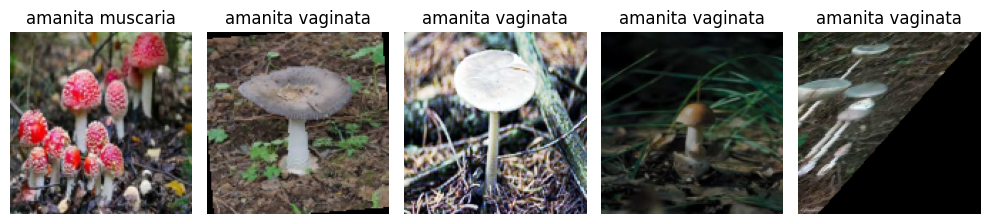

In [53]:
data.plot_dataloader_img(dataloader = train_loader_augmented,
                         n_images = 5,
                         classes = class_names)

In [54]:
utils.set_seed()
baseline_augmentation = utils.linear_baseline(input_height = 128,
                                              input_width = 128,
                                              color_channels = 3,
                                              output_shape = 4,
                                              num_layers = 3,
                                              num_neurons = 10).to(device)
baseline_augmentation

Baseline(
  (model): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=49152, out_features=10, bias=True)
    (2): ReLU()
    (3): Linear(in_features=10, out_features=10, bias=True)
    (4): ReLU()
    (5): Linear(in_features=10, out_features=10, bias=True)
    (6): ReLU()
    (7): Linear(in_features=10, out_features=4, bias=True)
  )
)

In [55]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(baseline_augmentation.parameters(),
                             lr=0.001)

In [57]:
start = timer()

baseline_augmentation_results = model_ops.train(model = baseline_augmentation,
                                                train_dataloader = train_loader_augmented,
                                                test_dataloader = val_loader_augmented,
                                                loss_function = loss_fn,
                                                optimizer = optimizer,
                                                metric = "accuracy",
                                                epochs = 20,
                                                device = "cpu",
                                                verbose = 2)
end = timer()

utils.delta_time(start, end)

Training:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 01: Train Loss: 1.362 | Train Accuracy: 32.50% | Test Loss: 1.348 | Test Accuracy: 32.03%
Epoch 02: Train Loss: 1.322 | Train Accuracy: 34.88% | Test Loss: 1.340 | Test Accuracy: 30.08%
Epoch 03: Train Loss: 1.291 | Train Accuracy: 36.25% | Test Loss: 1.345 | Test Accuracy: 29.69%
Epoch 04: Train Loss: 1.273 | Train Accuracy: 39.50% | Test Loss: 1.333 | Test Accuracy: 33.98%
Epoch 05: Train Loss: 1.276 | Train Accuracy: 39.50% | Test Loss: 1.281 | Test Accuracy: 40.62%


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a8c2804a8c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a8c2804a8c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Epoch 06: Train Loss: 1.287 | Train Accuracy: 38.25% | Test Loss: 1.328 | Test Accuracy: 37.89%
Epoch 07: Train Loss: 1.232 | Train Accuracy: 41.88% | Test Loss: 1.280 | Test Accuracy: 39.06%


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a8c2804a8c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a8c2804a8c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Epoch 08: Train Loss: 1.186 | Train Accuracy: 45.25% | Test Loss: 1.274 | Test Accuracy: 40.23%
Epoch 09: Train Loss: 1.158 | Train Accuracy: 46.38% | Test Loss: 1.299 | Test Accuracy: 37.89%


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a8c2804a8c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a8c2804a8c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Epoch 10: Train Loss: 1.101 | Train Accuracy: 50.50% | Test Loss: 1.264 | Test Accuracy: 44.14%


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a8c2804a8c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a8c2804a8c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Epoch 11: Train Loss: 1.100 | Train Accuracy: 51.12% | Test Loss: 1.291 | Test Accuracy: 40.23%


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a8c2804a8c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a8c2804a8c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Epoch 12: Train Loss: 1.020 | Train Accuracy: 57.38% | Test Loss: 1.274 | Test Accuracy: 43.75%


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a8c2804a8c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a8c2804a8c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Epoch 13: Train Loss: 0.949 | Train Accuracy: 61.12% | Test Loss: 1.270 | Test Accuracy: 44.92%


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a8c2804a8c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a8c2804a8c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Epoch 14: Train Loss: 0.913 | Train Accuracy: 60.62% | Test Loss: 1.233 | Test Accuracy: 46.88%


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a8c2804a8c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a8c2804a8c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Epoch 15: Train Loss: 0.873 | Train Accuracy: 63.88% | Test Loss: 1.298 | Test Accuracy: 46.48%


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a8c2804a8c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a8c2804a8c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Epoch 16: Train Loss: 0.842 | Train Accuracy: 64.88% | Test Loss: 1.381 | Test Accuracy: 41.02%


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a8c2804a8c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a8c2804a8c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Epoch 17: Train Loss: 0.813 | Train Accuracy: 66.88% | Test Loss: 1.473 | Test Accuracy: 39.06%


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a8c2804a8c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a8c2804a8c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Epoch 18: Train Loss: 0.774 | Train Accuracy: 68.00% | Test Loss: 1.439 | Test Accuracy: 41.02%


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a8c2804a8c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a8c2804a8c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Epoch 19: Train Loss: 0.720 | Train Accuracy: 70.50% | Test Loss: 1.439 | Test Accuracy: 42.97%


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a8c2804a8c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a8c2804a8c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Epoch 20: Train Loss: 0.677 | Train Accuracy: 72.12% | Test Loss: 1.363 | Test Accuracy: 46.48%
Total time: 00:01:54


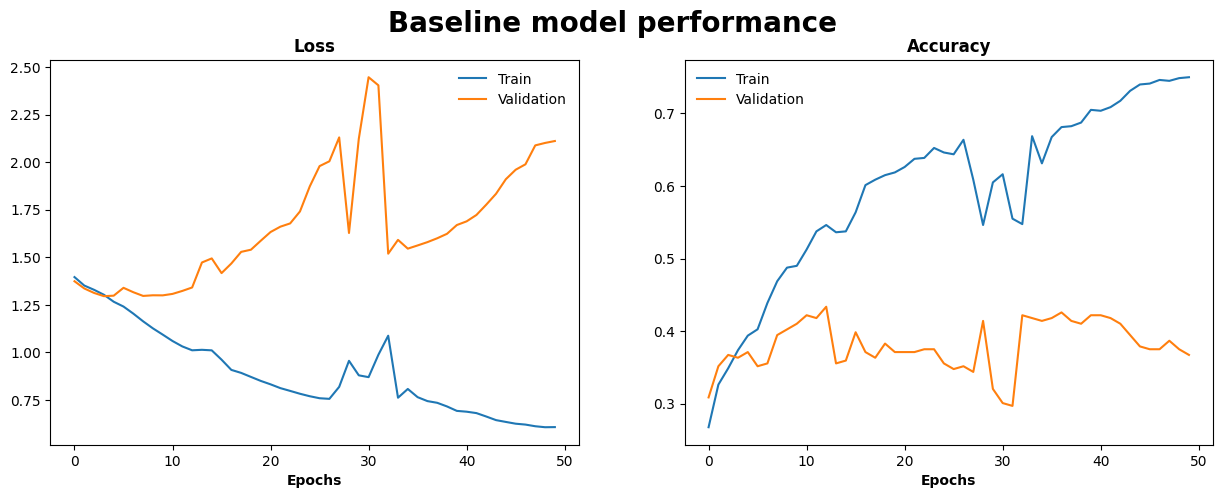

In [43]:
utils.plot_model_performance(results_dict = baseline_augmentation_results,
                             fig_size = (15, 5),
                             metric_name = "Accuracy",
                             title = "Baseline model performance on augmented data")

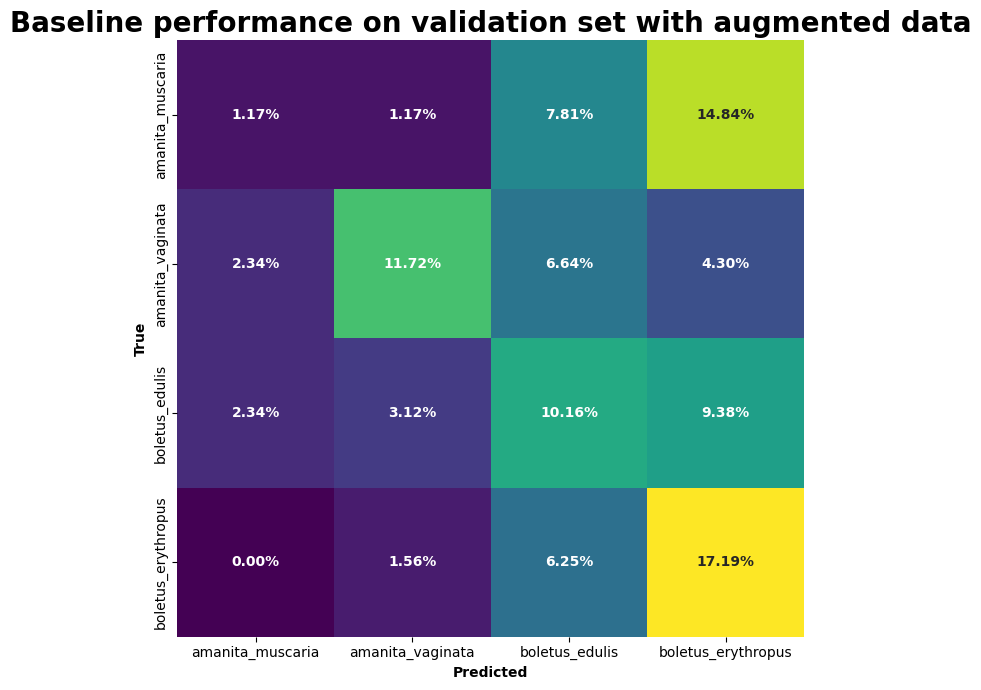

In [31]:
val_augemted_pred, val_augmented_true = model_ops.make_predictions(model = baseline_augmentation,
                                                                   test_dataloader = val_loader_augmented)

utils.plot_confusion_matrix(y_true = val_augmented_true,
                            y_pred = val_augemted_pred,
                            class_names = class_names,
                            norm = "all",
                            title = "Baseline performance on validation set with augmented data")